In [1]:
# !pip install tqdm==4.28.1
# !pip install -U gast==0.2.2
# !pip install gdown

# !gdown https://drive.google.com/uc?id=14CB3Vw4jPf-8-DAriB9XDq4mfbs4o747
# !mkdir datasets
# !tar -C datasets -xzf airport-alunos.tgz


In [1]:
import random

#%tensorflow_version 2.x
import tensorflow as tf; print(tf.__version__)
import tensorflow.keras
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


from sklearn.datasets import load_sample_image;
from sklearn.manifold import TSNE


import seaborn as sns


import numpy as np
import tqdm; print(tqdm.__version__)
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

2.0.0
4.28.1


In [2]:
def scatter(x, labels, subtitle='None'):
    # We choose a color palette with seaborn.
    palette_size = len(np.unique(labels))
    palette = np.array(sns.color_palette("hls", palette_size))
    
    color_map = dict({})
    color_count = 0
    for l in labels:
        if l not in color_map:
            color_map[l] = color_count
            color_count = color_count + 1
    
    def get_color_idx(label):
        return color_map[label]
        
    def get_colores_idx(labels_):
        return np.array([get_color_idx(l) for l in labels_])
        
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[get_colores_idx(labels)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for l, i in zip(labels, range(len(labels))):
        # Position of each label.
        xtext, ytext = np.median(x[labels == l, :], axis=0)
        txt = ax.text(xtext, ytext, labels[i], fontsize=16, 
                      color = palette[get_color_idx(l)]) #, bbox=dict(alpha=0.5))
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="yellow"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [3]:
def create_base_model(input_shape):
    input_layer = Input(shape = input_shape)
    
    model = Conv2D(8, (3, 3), activation = None, padding='same')(input_layer)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(16, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(32, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Conv2D(64, (3, 3), activation = None, padding='same')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D((2, 2))(model)
    
    model = Flatten()(model)
    model = Dense(64, activation='relu')(model)
    model = Lambda(lambda inp: K.l2_normalize(inp, axis=-1))(model)
    
    model = Model(inputs=input_layer, outputs=model)
    
    return model

def create_autoencoder(input_shape):
    input_layer = Input(shape = input_shape)
    
    model = Dense(64, activation='relu')(input_layer)
    model = Dense(32, activation='relu')(model)
    model = Dense(16, activation='relu')(model)
    model = Dense(32, activation='relu')(model)
    model = Dense(64, activation='relu')(model)
    model = Lambda(lambda inp: K.l2_normalize(inp, axis=-1))(model)
    
    model = Model(inputs=input_layer, outputs=model)
    
    return model
    
class TripletLossLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(TripletLossLayer, self).__init__()
    
    def euclidean_distance(self, vects):
        x, y = vects
        x = tf.cast(x, 'float32')
        y = tf.cast(y, 'float32')

        return K.mean(K.sum(K.square(x-y),axis=1))
    
    def call(self, inputs=None):
        #     Calcule triplet loss 
        #     loss = max(dist(a, p) - dist(a, n) + margin, 0)
        self.margin = tf.constant(0.4 , dtype='float32')
        a, p, n = inputs
        a = tf.cast(a, 'float32')
        p = tf.cast(p, 'float32')
        n = tf.cast(n, 'float32')
        
        # Calcule triplet loss 
        subt_ = tf.subtract(self.euclidean_distance([a, p]) , self.euclidean_distance([a, n]))
        sum_ = tf.add(subt_, self.margin)
        
        loss = K.maximum(sum_, 0.0)
        # add in model loss
        self.add_loss(loss)
    
        return a

In [4]:
adam = tf.keras.optimizers.Adam(learning_rate=0.00001)

# input_shape = (28, 28, 1)
input_shape = (128, 64, 3)

## Defining S1

In [5]:
base_network_s1 = create_base_model(input_shape)

input_anchor = Input(shape=input_shape)
input_positive = Input(shape=input_shape)
input_negative = Input(shape=input_shape)

processed_a = base_network_s1(input_anchor)
processed_p = base_network_s1(input_positive)
processed_n = base_network_s1(input_negative)

loss_layer_s1 = TripletLossLayer()([processed_a, processed_p, processed_n])

s1 = Model([input_anchor, input_positive, input_negative], loss_layer_s1)

s1.compile(optimizer=adam, loss=(lambda y_true, ypred: 0.0))

s1_embs_model = base_network_s1
s1_embs_model.compile(loss=(lambda y_true, ypred: 0.0))

## Defining S2

In [6]:
base_network_s2 = create_base_model(input_shape)
autoencoder_s2 = create_autoencoder((64,))

d = Dense(64, activation='relu')(base_network_s2.output)
middle_model_s2 = Model(base_network_s2.input, d)

connect = autoencoder_s2(middle_model_s2.output)
middle_model_s2 = Model(base_network_s2.input, connect)

input_anchor_s2 = Input(shape=input_shape)
input_positive_s2 = Input(shape=input_shape)
input_negative_s2 = Input(shape=input_shape)

processed_a_s2 = middle_model_s2(input_anchor_s2)
processed_p_s2 = middle_model_s2(input_positive_s2)
processed_n_s2 = middle_model_s2(input_negative_s2)

loss_layer_s2 = TripletLossLayer()([processed_a_s2, processed_p_s2, processed_n_s2])

s2 = Model([input_anchor_s2, input_positive_s2, input_negative_s2], 
           loss_layer_s2)
s2.compile(optimizer=adam, loss=(lambda y_true, ypred: 0.0))

s2_embs_model = base_network_s2
s2_embs_model.compile(loss=(lambda y_true, ypred: 0.0))

## Defining S3

In [7]:
base_network_s3 = create_base_model(input_shape)
autoencoder_s3 = create_autoencoder((64,))

d = Dense(64, activation='relu')(base_network_s3.output)
middle_model_s3 = Model(base_network_s3.input, d)

connect3 = autoencoder_s3(middle_model_s3.output)
middle_model_s3 = Model(base_network_s3.input, connect3)

input_anchor_s3 = Input(shape=input_shape)
input_positive_s3 = Input(shape=input_shape)
input_negative_s3 = Input(shape=input_shape)

processed_a_s3 = middle_model_s3(input_anchor_s3)
processed_p_s3 = middle_model_s3(input_positive_s3)
processed_n_s3 = middle_model_s3(input_negative_s3)

loss_layer_s3 = TripletLossLayer()([processed_a_s3, processed_p_s3, processed_n_s3])

s3 = Model([input_anchor_s3, input_positive_s3, input_negative_s3], 
           loss_layer_s3)
s3.compile(optimizer=adam, loss=(lambda y_true, ypred: 0.0))

s3_embs_model = base_network_s3
s3_embs_model.compile(loss=(lambda y_true, ypred: 0.0))

## Experiments with MNIST (IGNORE)

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float')

### Show TSNE Before Training

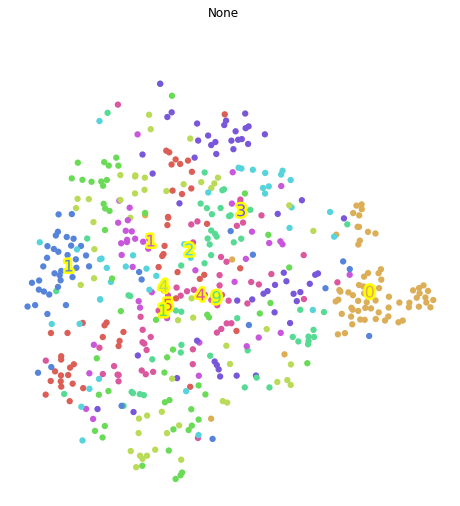

In [10]:
embs = embs_model.predict(x_train[:512])
labels = y_train[:512]
embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels)

In [17]:
def create_triplets(num_batches, batch_size):
    for _ in range(num_batches):
#     while True:
        batch = []
        clazz = []
        for _ in range(batch_size):
            grps_number = [1, 2, 3, 4, 5 ,6, 7, 8, 9, 0]
            
            grp = random.choice(grps_number)
            grps_number.remove(grp)
            img_a = x_train[y_train==grp][np.random.randint(x_train[y_train==grp].shape[0])]
            img_p = x_train[y_train==grp][np.random.randint(x_train[y_train==grp].shape[0])]
            
            grp_2 = random.choice(grps_number)
            img_n = x_train[y_train==grp_2][np.random.randint(x_train[y_train==grp_2].shape[0])]
            
            batch.append([img_a, img_p, img_n])
        out = np.array(batch)
        yield [out[:, i] for i in range(3)]

In [24]:
for inp_ in create_triplets(3000, 4):
    print(np.array(inp_).shape)
    break

(3, 4, 28, 28, 1)


In [23]:
print(np.array(X_train).shape)

(512, 3, 128, 64, 3)


In [12]:
batch_size = 64
y_true = np.array([[0.0 for _ in range(64)] for _ in range(batch_size)])


early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0,
                                                         verbose=0, restore_best_weights=True)

for inp_ in create_triplets(3000, batch_size):
    model.fit(inp_ , y_true, batch_size=5, epochs=1000000, callbacks=[early_stopping], shuffle=True, validation_split=0.5)

Train on 32 samples, validate on 32 samples
Epoch 1/1000000
32/32 [==============================] - 8s 249ms/sample - loss: 0.7618 - val_loss: 0.0376
Epoch 2/1000000
32/32 [==============================] - 0s 7ms/sample - loss: 0.0000e+00 - val_loss: 0.0555
Epoch 3/1000000
32/32 [==============================] - 0s 5ms/sample - loss: 0.0000e+00 - val_loss: 0.0522
Epoch 4/1000000
32/32 [==============================] - 0s 4ms/sample - loss: 0.3959 - val_loss: 0.0000e+00
Epoch 5/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/1000000
32/32 [==============================] - 0s 3ms/sample - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/1000000
32/32 [==============================] - 0s 4ms/sample

KeyboardInterrupt: 

### Show TSNE After Training

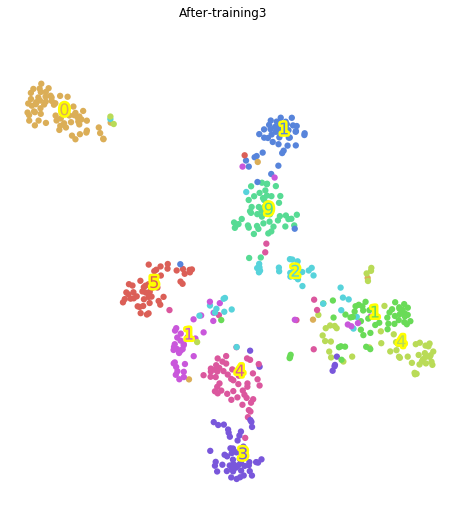

In [13]:
embs = embs_model.predict(x_train[:512])
labels = y_train[:512]
embs_2d = TSNE().fit_transform(embs)
scatter(embs_2d, labels, subtitle="After-training3")

## Experiments With Real Dataset

In [38]:
from tripplet_data import *

def map_person_to_filepaths(folder='treino'):
    path = 'datasets/airport-alunos/' + folder + '/'
    images_per_person = {}
    
    for i in range(2):
        for (person, person_path) in map_person_files(path + str(i) +'/').items():
            for pp in person_path:
                if person not in images_per_person:
                    images_per_person[person] = []

                for img in list_person_files(pp):
                    images_per_person[person].append(pp + img)
            
    return images_per_person 

def create_embeddings(map_files, embs_model, debbug=False):
    embeddings_per_person = {}
    images_per_person = {}

    total = len(map_files)
    count = 1
    for (person, images_path) in map_files.items():
        np_images = []
        for ip in images_path:
            np_image = img_to_array(load_img(ip))
            np_images.append(np_image)
        
        if debbug:
            print("(" + str(count)+ "/" + str(total) +") predicting to person "+ person)
            
        count = count + 1
        embs_output = embs_model.predict(np.array(np_images))
        
        images_per_person[person] = np_images
        embeddings_per_person[person] = embs_output
    
    return embeddings_per_person, images_per_person


def create_triplets(number_of_triples, embeddings_map, images_map):
    while True:
        def get_distance(emb1, emb2):
            return np.sqrt(np.sum(np.power((emb1 - emb2), 2)))
        persons = np.array([name for (name, _) in embeddings_map.items()])

        anchors = np.zeros(shape=(0,128, 64, 3))
        positives = np.zeros(shape=(0,128, 64, 3))
        negatives = np.zeros(shape=(0,128, 64, 3))

        for _ in range(number_of_triples):
            anchor_person = random.choice(persons)
            neg_person = anchor_person
            while anchor_person == neg_person:
                neg_person = random.choice(persons)

            anchor_idx = np.random.randint(len(embeddings_map[anchor_person]))
            anchor_emb = embeddings_map[anchor_person][anchor_idx]
            anchor_img = images_map[anchor_person][anchor_idx]

            # Select the farthest on as positive
            positive_img = random.choice(images_map[anchor_person])

            # Select the nearst on as negative
            negative_img = random.choice(images_map[neg_person])

            anchors = np.append( anchors,  np.expand_dims(anchor_img, axis=0), axis=0)
            positives = np.append( positives,  np.expand_dims(positive_img, axis=0), axis=0)
            negatives = np.append( negatives,  np.expand_dims(negative_img, axis=0), axis=0)

        y_true = np.array([[0.0 for _ in range(64)] for _ in range(number_of_triples)])

        yield [anchors, positives, negatives], y_true

### S1

### Show TSNE Before Training

In [10]:
embeddings, images = create_embeddings(map_person_to_filepaths('val'), s1_embs_model, debbug=True)

(1/50) predicting to person 235
(2/50) predicting to person 207
(3/50) predicting to person 230
(4/50) predicting to person 237
(5/50) predicting to person 247
(6/50) predicting to person 228
(7/50) predicting to person 210
(8/50) predicting to person 222
(9/50) predicting to person 227
(10/50) predicting to person 206
(11/50) predicting to person 249
(12/50) predicting to person 244
(13/50) predicting to person 202
(14/50) predicting to person 205
(15/50) predicting to person 232
(16/50) predicting to person 239
(17/50) predicting to person 203
(18/50) predicting to person 214
(19/50) predicting to person 231
(20/50) predicting to person 240
(21/50) predicting to person 246
(22/50) predicting to person 213
(23/50) predicting to person 223
(24/50) predicting to person 234
(25/50) predicting to person 248
(26/50) predicting to person 229
(27/50) predicting to person 209
(28/50) predicting to person 221
(29/50) predicting to person 200
(30/50) predicting to person 242
(31/50) predicting 

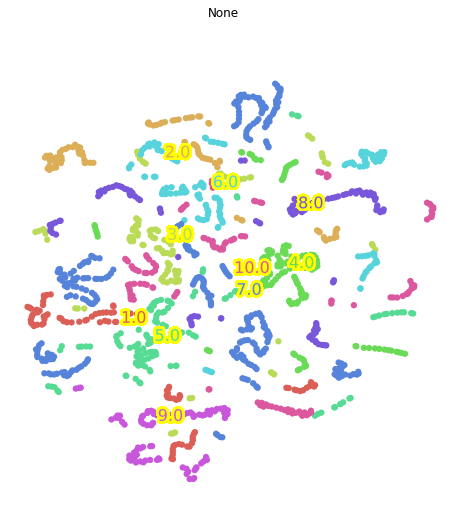

In [42]:
combined_embs = np.zeros(shape=(0,64))
labels = np.zeros(shape=(0,1))
count = 1
for (person, embs) in embeddings.items():
    combined_embs = np.append( combined_embs,  embs, axis=0)
    l = np.zeros((len(embs), 1)) + count
    labels = np.append( labels,  l, axis=0)
    count = count + 1
    if count>10:
        break

labels = labels.flatten()
embs_2d = TSNE().fit_transform(combined_embs)
scatter(embs_2d, labels)

In [44]:
s1.fit_generator(create_triplets(50, embeddings, images), epochs=1000, steps_per_epoch=50)

Epoch 1/1000
50/50 [==============================] - 45s 896ms/step - loss: 0.1478
Epoch 2/1000
50/50 [==============================] - 42s 839ms/step - loss: 0.1166
Epoch 3/1000
50/50 [==============================] - 43s 861ms/step - loss: 0.0862
Epoch 4/1000
50/50 [==============================] - 42s 844ms/step - loss: 0.0669
Epoch 5/1000
50/50 [==============================] - 42s 832ms/step - loss: 0.0570
Epoch 6/1000
50/50 [==============================] - 42s 846ms/step - loss: 0.0490
Epoch 7/1000
50/50 [==============================] - 42s 840ms/step - loss: 0.0184
Epoch 8/1000
50/50 [==============================] - 42s 841ms/step - loss: 0.0320
Epoch 9/1000
50/50 [==============================] - 42s 834ms/step - loss: 0.0178
Epoch 10/1000
50/50 [==============================] - 42s 838ms/step - loss: 0.0268
Epoch 11/1000
50/50 [==============================] - 42s 841ms/step - loss: 0.0206
Epoch 12/1000
50/50 [==============================] - 41s 827ms/step - lo

KeyboardInterrupt: 

### Show TSNE After Training

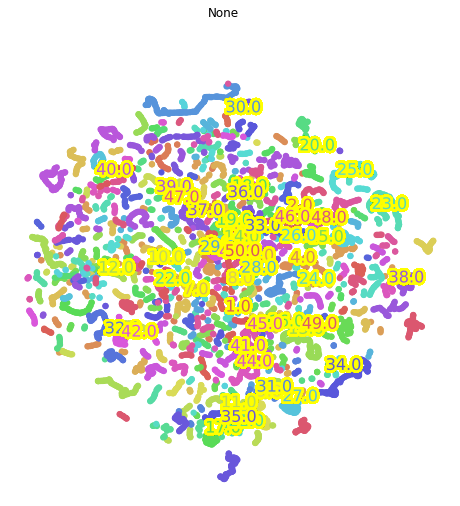

In [46]:
combined_embs = np.zeros(shape=(0,64))
labels = np.zeros(shape=(0,1))
count = 1
for (person, embs) in embeddings.items():
    combined_embs = np.append( combined_embs,  embs, axis=0)
    l = np.zeros((len(embs), 1)) + count
    labels = np.append( labels,  l, axis=0)
    count = count + 1
#     if count>10:
#         break

labels = labels.flatten()
embs_2d = TSNE().fit_transform(combined_embs)
scatter(embs_2d, labels)

## Evaluation of model

* Get Embeddings
* Create a shallow neural network
* Train this network to decide if two embs is from the same person

In [61]:
embs_anchor_val = embs_model.predict(X_val[0])
embs_pos_val = embs_model.predict(X_val[1])
embs_neg_val = embs_model.predict(X_val[2])

embs_anchor_train = embs_model.predict(X_train[0])
embs_pos_train = embs_model.predict(X_train[1])
embs_neg_train = embs_model.predict(X_train[2])

In [58]:
pred_model_inp_a = Input(shape=(64,))
pred_model_inp_b = Input(shape=(64,))

pred_model = Dense(64, activation='relu')(tf.keras.layers.concatenate([pred_model_inp_a, pred_model_inp_b]))
pred_model = Dense(32, activation='relu')(pred_model)
pred_model_output = Dense(1, activation='sigmoid')(pred_model)

pred_model = Model(inputs=[pred_model_inp_a, pred_model_inp_b], outputs=pred_model_output)

pred_model.compile(loss='binary_crossentropy')
pred_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 128)          0           input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 64)           8256        concatenate_4[0][0]        

In [175]:
early_stopping =  tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0,
                                                         verbose=1)
for _ in range(10):
    person_1 = []
    person_2 = []
    y_true = []
    for i in range(100000):
        person_idx = np.random.randint(embs_anchor_train.shape[0])
        person_1.append(embs_anchor_train[person_idx])
        
        if random.random()>.5: # same person
            person_2.append(embs_pos_train[person_idx])
            y_true.append(1)
        else: # different person
            person_2.append(embs_neg_train[person_idx])
            y_true.append(0)

    pred_model.fit([np.array(person_1), np.array(person_2)], np.array(y_true), 
                   epochs=5000, callbacks=[early_stopping])
    


Train on 100000 samples
Epoch 1/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4496
Epoch 2/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4410
Epoch 3/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4366
Epoch 4/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4307
Epoch 5/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4283
Epoch 6/5000
100000/100000 [==============================] - 9s 91us/sample - loss: 0.4245
Epoch 7/5000
100000/100000 [==============================] - 9s 94us/sample - loss: 0.4216
Epoch 8/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4188
Epoch 9/5000
100000/100000 [==============================] - 9s 92us/sample - loss: 0.4162
Epoch 10/5000
100000/100000 [==============================] - 9s 93us/sample - loss: 0.4131
Epoch 11/5000
100000/100000 [==========================

In [240]:
person_1 = []
person_2 = []
y_true = []
for i in range(10000):
    person_idx = np.random.randint(embs_anchor_val.shape[0])
    person_1.append(embs_anchor_val[person_idx])

    if random.random()>.5: # same person
        person_2.append(embs_pos_val[person_idx])
        y_true.append(1)
    else: # different person
        person_2.append(embs_neg_val[person_idx])
        y_true.append(0)

y_pred = (pred_model.predict([np.array(person_1), np.array(person_2)]) > .5).flatten()
y_true = np.array(y_true) > .5
accuracy = np.sum(y_pred==y_true)/len(y_true)*100

print(accuracy)

71.38


In [241]:
pred_model.save('pred_model.h5')